In [1]:
import string
import os
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

import gensim
from gensim.models import Word2Vec

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Conv1D, Dropout, Activation, GlobalMaxPooling1D, Reshape
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Pre-processing

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/georgie-talukdar/Can-you-judge-a-book-by-its-cover/main/Data/tabular_classification.csv')

In [4]:
df.head()

,Title,ID,Cover,Genres,Action and Adventure,Animals,Art,Children,Contemporary,Crime,...,War,Women,author,year,total_weeks,first_week,debut_rank,best_rank,Equal-Frequency,success
0,H IS FOR HOMICIDE,/works/OL14852185W,579109,"['Women', 'Mystery and Detective', 'Fiction']",0,0,0,0,0,0,...,0,1,Sue Grafton,1991,15,1991-05-05,15,2,13.0 < x ≤ 178.0,excellent
1,H IS FOR HOMICIDE,/works/OL14852185W,3108161,"['Women', 'Mystery and Detective', 'Fiction']",0,0,0,0,0,0,...,0,1,Sue Grafton,1991,15,1991-05-05,15,2,13.0 < x ≤ 178.0,excellent
2,H IS FOR HOMICIDE,/works/OL14852185W,226697,"['Women', 'Mystery and Detective', 'Fiction']",0,0,0,0,0,0,...,0,1,Sue Grafton,1991,15,1991-05-05,15,2,13.0 < x ≤ 178.0,excellent
3,I IS FOR INNOCENT,/works/OL14852192W,579110,"['Fiction', 'Women', 'Mystery and Detective']",0,0,0,0,0,0,...,0,1,Sue Grafton,1992,11,1992-04-26,2,2,7.0 < x ≤ 13.0,good
4,G IS FOR GUMSHOE,/works/OL14852180W,579057,"['Women', 'Mystery and Detective', 'Fiction']",0,0,0,0,0,0,...,0,1,Sue Grafton,1990,6,1990-05-06,8,8,4.0 < x ≤ 7.0,average


In [5]:
textual_df = df[['Title','author','success']]

In [6]:
textual_df.head()

,Title,author,success
0,H IS FOR HOMICIDE,Sue Grafton,excellent
1,H IS FOR HOMICIDE,Sue Grafton,excellent
2,H IS FOR HOMICIDE,Sue Grafton,excellent
3,I IS FOR INNOCENT,Sue Grafton,good
4,G IS FOR GUMSHOE,Sue Grafton,average


In [7]:
# Clean data using the built in cleaner in gensim
textual_df['text_clean'] = textual_df['Title'].apply(lambda x: gensim.utils.simple_preprocess(x))
textual_df.head()

<ipython-input-7-9fbbce5da244>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textual_df['text_clean'] = textual_df['Title'].apply(lambda x: gensim.utils.simple_preprocess(x))


,Title,author,success,text_clean
0,H IS FOR HOMICIDE,Sue Grafton,excellent,"[is, for, homicide]"
1,H IS FOR HOMICIDE,Sue Grafton,excellent,"[is, for, homicide]"
2,H IS FOR HOMICIDE,Sue Grafton,excellent,"[is, for, homicide]"
3,I IS FOR INNOCENT,Sue Grafton,good,"[is, for, innocent]"
4,G IS FOR GUMSHOE,Sue Grafton,average,"[is, for, gumshoe]"


In [8]:
textual_df['author'] = textual_df['author'].apply(lambda x: x.lower())
textual_df['author'] = textual_df['author'].str.replace('[{}]'.format(string.punctuation), ' ')

<ipython-input-8-6131dde8b281>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textual_df['author'] = textual_df['author'].apply(lambda x: x.lower())
<ipython-input-8-6131dde8b281>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  textual_df['author'] = textual_df['author'].str.replace('[{}]'.format(string.punctuation), ' ')
<ipython-input-8-6131dde8b281>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  textual_df['author'] = textual_df['author'].str.replace

In [9]:
textual_df.head()

,Title,author,success,text_clean
0,H IS FOR HOMICIDE,sue grafton,excellent,"[is, for, homicide]"
1,H IS FOR HOMICIDE,sue grafton,excellent,"[is, for, homicide]"
2,H IS FOR HOMICIDE,sue grafton,excellent,"[is, for, homicide]"
3,I IS FOR INNOCENT,sue grafton,good,"[is, for, innocent]"
4,G IS FOR GUMSHOE,sue grafton,average,"[is, for, gumshoe]"


In [10]:
# Extract the 'author' column as a separate DataFrame
author_column = textual_df[['author']]

# Create an instance of OneHotEncoder
encoder = OneHotEncoder()

# Fit and transform the 'author' column
onehot_encoded = encoder.fit_transform(author_column)

# Convert the sparse matrix to a dense array
onehot_encoded = onehot_encoded.toarray()

# Create a new DataFrame with the one-hot encoded features
onehot_df = pd.DataFrame(onehot_encoded, columns=encoder.categories_[0])

# Concatenate the one-hot encoded DataFrame with the original DataFrame
textual_df_encoded = pd.concat([textual_df, onehot_df], axis=1)

textual_df_encoded.head()

,Title,author,success,text_clean,martha grimes,elizabeth forsythe hailey,james a michener,a a milne,a j cronin,a s byatt,...,winifred holtby,winston groom,wm paul young,yaa gyasi,yael dayan,yangsze choo,yann martel,yukio mishima,zadie smith,zoe oldenbourg
0,H IS FOR HOMICIDE,sue grafton,excellent,"[is, for, homicide]",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,H IS FOR HOMICIDE,sue grafton,excellent,"[is, for, homicide]",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,H IS FOR HOMICIDE,sue grafton,excellent,"[is, for, homicide]",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,I IS FOR INNOCENT,sue grafton,good,"[is, for, innocent]",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,G IS FOR GUMSHOE,sue grafton,average,"[is, for, gumshoe]",0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
y = textual_df_encoded[['success']]

X = textual_df_encoded.drop(['Title', 'author', 'success'], axis=1)

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=df['success'])
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val)

In [12]:
X_train

,text_clean,martha grimes,elizabeth forsythe hailey,james a michener,a a milne,a j cronin,a s byatt,a a milnei,a b guthrie jr,a b guthrie jr,...,winifred holtby,winston groom,wm paul young,yaa gyasi,yael dayan,yangsze choo,yann martel,yukio mishima,zadie smith,zoe oldenbourg
4888,"[the, bourne, dominion]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,"[false, memory]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7956,"[when, the, whippoorwill]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1073,"[find, her]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5234,"[the, delta, decision]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,"[mountain, meadow]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2890,"[night, probe]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7241,"[the, war, between, the, tates]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3095,"[on, the, road]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Convert string labels to integer labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
y_val_encoded = label_encoder.transform(y_val)

# Convert labels to one-hot encoded format
y_train = to_categorical(y_train_encoded, num_classes=5)
y_test = to_categorical(y_test_encoded, num_classes=5)
y_val = to_categorical(y_val_encoded, num_classes=5)

# Reverse the one-hot encoding and get the original label names
reverse_mapping = {index: label for index, label in enumerate(label_encoder.inverse_transform(range(len(label_encoder.classes_))))}

# Create a mapping dictionary for later use
mapping_dict = {index: category for index, category in reverse_mapping.items()}

# Print the mapping values to the categorical labels
for index, category in mapping_dict.items():
    print(f"Value: {index} - Category: {category}")


Value: 0 - Category: average
Value: 1 - Category: excellent
Value: 2 - Category: good
Value: 3 - Category: mediocre
Value: 4 - Category: poor


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [14]:
mapping_dict

{0: 'average', 1: 'excellent', 2: 'good', 3: 'mediocre', 4: 'poor'}

In [15]:
y_val

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [16]:
corpus_size = len(X_train['text_clean'])
print("Corpus size:", corpus_size)

Corpus size: 5456


 By default, the Word2Vec function from the gensim library uses the Skip-gram architecture

In [17]:
# Train the word2vec model
w2v_model = gensim.models.Word2Vec(X_train['text_clean'],
                                   vector_size=200,
                                   window=5,
                                   min_count=1)

In [18]:
w2v_model.wv.index_to_key

['the',
 'of',
 'in',
 'and',
 'to',
 'for',
 'you',
 'dark',
 'night',
 'last',
 'death',
 'one',
 'my',
 'prey',
 'on',
 'me',
 'man',
 'is',
 'blood',
 'from',
 'all',
 'no',
 'star',
 'time',
 'road',
 'at',
 'house',
 'fire',
 'girl',
 'life',
 'love',
 'secret',
 'dead',
 'lost',
 'white',
 'cross',
 'with',
 'christmas',
 'game',
 'first',
 'heart',
 'shadow',
 'woman',
 'world',
 'day',
 'home',
 'red',
 'street',
 'summer',
 'wars',
 'blue',
 'light',
 'who',
 'bones',
 'two',
 'good',
 'by',
 'king',
 'storm',
 'her',
 'book',
 'other',
 'dragon',
 'second',
 'midnight',
 'an',
 'gone',
 'long',
 'this',
 'cat',
 'river',
 'island',
 'god',
 'we',
 'end',
 'cold',
 'girls',
 'song',
 'jedi',
 'place',
 'water',
 'country',
 'men',
 'moon',
 'story',
 'lord',
 'new',
 'land',
 'family',
 'mr',
 'honor',
 'sea',
 'fall',
 'perfect',
 'justice',
 'little',
 'order',
 'after',
 'high',
 'heaven',
 'true',
 'days',
 'dream',
 'not',
 'are',
 'silent',
 'affair',
 'old',
 'angels',

In [19]:
w2v_model.wv.most_similar('murder')

[('the', 0.7715455293655396),
 ('to', 0.7699615359306335),
 ('of', 0.7682239413261414),
 ('for', 0.7653167247772217),
 ('in', 0.7635809183120728),
 ('on', 0.7619906067848206),
 ('me', 0.75736403465271),
 ('you', 0.7551292181015015),
 ('all', 0.7514204978942871),
 ('my', 0.7502731084823608)]

In [20]:
words = set(w2v_model.wv.index_to_key )
X_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_train['text_clean']], dtype=object)
X_test_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_test['text_clean']], dtype=object)
X_val_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in X_val['text_clean']], dtype=object)

In [27]:
X_train_vect.size

5456

In [21]:
X_train

,text_clean,martha grimes,elizabeth forsythe hailey,james a michener,a a milne,a j cronin,a s byatt,a a milnei,a b guthrie jr,a b guthrie jr,...,winifred holtby,winston groom,wm paul young,yaa gyasi,yael dayan,yangsze choo,yann martel,yukio mishima,zadie smith,zoe oldenbourg
4888,"[the, bourne, dominion]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,"[false, memory]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7956,"[when, the, whippoorwill]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1073,"[find, her]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5234,"[the, delta, decision]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,"[mountain, meadow]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2890,"[night, probe]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7241,"[the, war, between, the, tates]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3095,"[on, the, road]",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# combine cleaned text with author features and pad sequences
X_train_vect_avg = []
for v, row in zip(X_train_vect, X_train.iterrows()):
    author_features = row[1].drop('text_clean').values
    if v.size:
        sentence_vector = np.concatenate([v.mean(axis=0), author_features])
    else:
        sentence_vector = np.concatenate([np.zeros(200, dtype=float), author_features])
    X_train_vect_avg.append(sentence_vector)

X_test_vect_avg = []
for v, row in zip(X_test_vect, X_test.iterrows()):
    author_features = row[1].drop('text_clean').values
    if v.size:
        sentence_vector = np.concatenate([v.mean(axis=0), author_features])
    else:
        sentence_vector = np.concatenate([np.zeros(200, dtype=float), author_features])
    X_test_vect_avg.append(sentence_vector)

X_val_vect_avg = []
for v, row in zip(X_val_vect, X_val.iterrows()):
    author_features = row[1].drop('text_clean').values
    if v.size:
        sentence_vector = np.concatenate([v.mean(axis=0), author_features])
    else:
        sentence_vector = np.concatenate([np.zeros(200, dtype=float), author_features])
    X_val_vect_avg.append(sentence_vector)


In [24]:
labels = ['poor', 'mediocre', 'average', 'good', 'excellent']

# Random Forest

Precision: 0.792 / Recall: 0.583 / Accuracy: 4.441
Classification Report:
              precision    recall  f1-score   support

        poor       0.29      0.96      0.45       293
    mediocre       0.96      0.51      0.67       341
     average       0.74      0.51      0.60       288
        good       0.99      0.50      0.66       282
   excellent       0.98      0.44      0.60       502

    accuracy                           0.56      1706
   macro avg       0.79      0.58      0.60      1706
weighted avg       0.82      0.56      0.60      1706



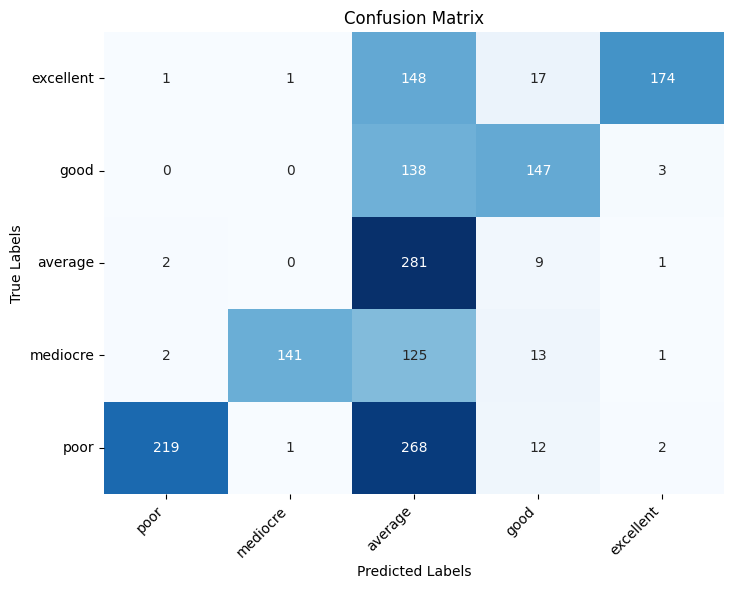

In [ ]:
# Instantiate and fit a basic Random Forest model on top of the vectors
rf = RandomForestClassifier()
rf_model = rf.fit(X_train_vect_avg, y_train)

# Use the trained model to make predictions on the test data
y_pred = rf_model.predict(X_test_vect_avg)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
recall = recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='macro')
accuracy = (y_pred == y_test).sum() / len(y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=labels)
print("Classification Report:")
print(report)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test.argmax(axis=1)]
y_pred_decoded = [mapping_dict[label] for label in y_pred.argmax(axis=1)]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


# LSVM

Precision: 0.495 / Recall: 0.478 / Accuracy: 0.51
Classification Report:
              precision    recall  f1-score   support

        poor       0.46      0.36      0.41       293
    mediocre       0.61      0.62      0.61       341
     average       0.47      0.34      0.39       288
        good       0.40      0.37      0.39       282
   excellent       0.53      0.70      0.60       502

    accuracy                           0.51      1706
   macro avg       0.49      0.48      0.48      1706
weighted avg       0.50      0.51      0.50      1706



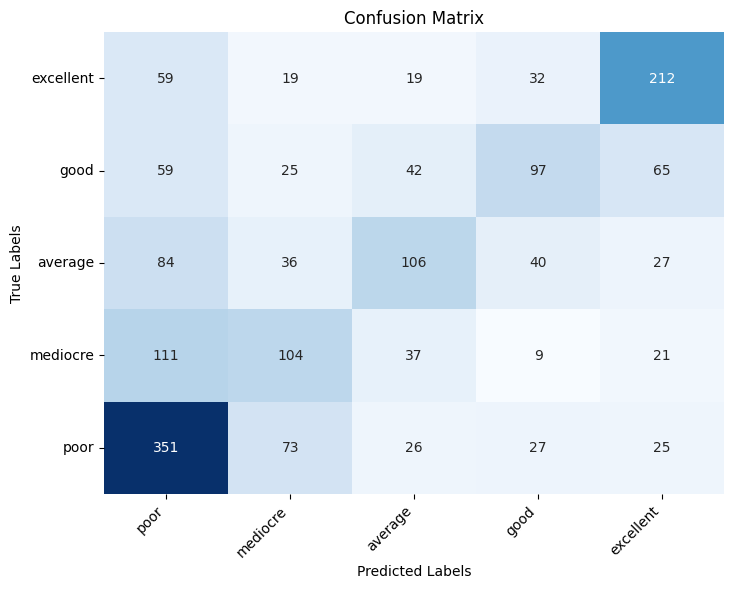

In [ ]:
# Convert one-hot encoded  to 1-dimensional array
y_test_labels = np.argmax(y_test, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

# Instantiate and fit a Linear Support Vector Machine model on top of the vectors
svm = LinearSVC()
svm_model = svm.fit(X_train_vect_avg, y_train_labels)

# Use the trained model to make predictions on the test data
y_pred = svm_model.predict(X_test_vect_avg)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test_labels, y_pred, average='macro')
recall = recall_score(y_test_labels, y_pred, average='macro')
accuracy = (y_pred == y_test_labels).sum() / len(y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test_labels, y_pred, target_names=labels)
print("Classification Report:")
print(report)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test_labels]
y_pred_decoded = [mapping_dict[label] for label in y_pred]

# Create the confusion matrix
labels = ['poor', 'mediocre', 'average', 'good', 'excellent']
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


# Logistic regression

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Precision: 0.485 / Recall: 0.467 / Accuracy: 0.504
Classification Report:
              precision    recall  f1-score   support

        poor       0.46      0.35      0.40       293
    mediocre       0.60      0.63      0.61       341
     average       0.45      0.33      0.38       288
        good       0.39      0.31      0.35       282
   excellent       0.52      0.72      0.60       502

    accuracy                           0.50      1706
   macro avg       0.48      0.47      0.47      1706
weighted avg       0.49      0.50      0.49      1706



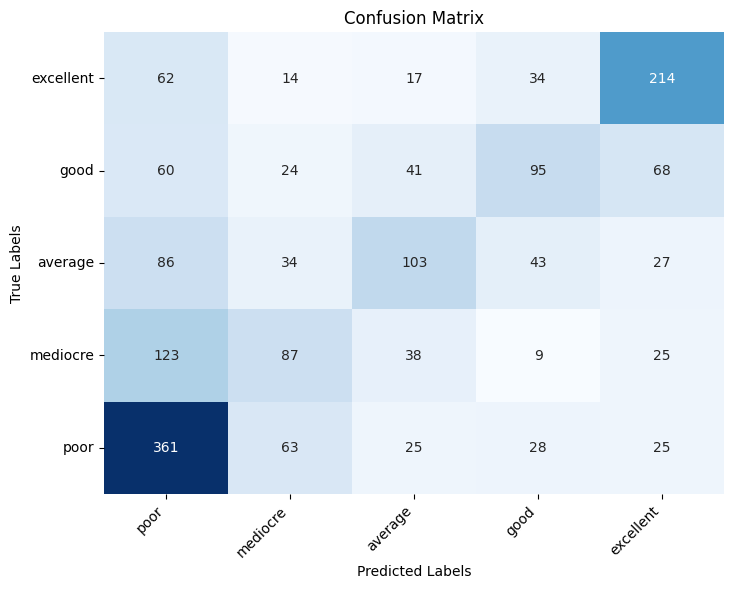

In [ ]:
# Convert one-hot encoded y_test to 1-dimensional array
y_test_labels = np.argmax(y_test, axis=1)
y_train_labels = np.argmax(y_train, axis=1)

# Instantiate and fit a Logistic Regression model on top of the vectors
logreg = LogisticRegression()
logreg_model = logreg.fit(X_train_vect_avg, y_train_labels)

# Use the trained model to make predictions on the test data
y_pred = logreg_model.predict(X_test_vect_avg)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test_labels, y_pred, average='macro')
recall = recall_score(y_test_labels, y_pred, average='macro')
accuracy = (y_pred == y_test_labels).sum() / len(y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test_labels, y_pred, target_names=labels)
print("Classification Report:")
print(report)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test_labels]
y_pred_decoded = [mapping_dict[label] for label in y_pred]

# Create the confusion matrix
labels = ['poor', 'mediocre', 'average', 'good', 'excellent']
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


In [ ]:
y_test_decoded

array([1, 2, 1, ..., 1, 0, 4])

# Simple Neural Network




In [ ]:
# Convert one-hot encoded y_test to 1-dimensional array
y_test_labels = np.argmax(y_test, axis=1)
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

X_train_vect_avg = np.array(X_train_vect_avg, dtype=np.float32)
X_test_vect_avg = np.array(X_test_vect_avg, dtype=np.float32)
X_val_vect_avg = np.array(X_val_vect_avg, dtype=np.float32)

# Define the input shape based on X_train_vect_avg
input_shape = X_train_vect_avg.shape[1:]

# model architecture
input_text = Input(shape=input_shape)
word_encoder = Dense(units=64, activation='relu')(input_text)
interaction = Dense(units=5, activation='softmax')(word_encoder)
output = Dense(units=5, activation='softmax')(interaction)

# Build the model
model = Model(inputs=input_text, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Train the model with early stopping
model.fit(X_train_vect_avg, y_train, epochs=1000, batch_size=32, validation_data=(X_val_vect_avg, y_val), callbacks=[early_stopping])

# Use the trained model to make predictions on the test data
y_pred_prob = model.predict(X_test_vect_avg)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test_labels, y_pred, average='macro')
recall = recall_score(y_test_labels, y_pred, average='macro')
accuracy = (y_pred == y_test_labels).sum() / len(y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test_labels, y_pred, target_names=labels)
print("Classification Report:")
print(report)

# Save the best model weights
save_dir = '/content/drive/MyDrive/covers/model_3_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'EXAM_weights.h5'))

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test_labels]
y_pred_decoded = [mapping_dict[label] for label in y_pred]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()



54/54 [==============================] - 0s 1ms/step
Precision: 0.653 / Recall: 0.645 / Accuracy: 0.649
Classification Report:
              precision    recall  f1-score   support

        poor       0.50      0.69      0.58       293
    mediocre       0.73      0.71      0.72       341
     average       0.53      0.62      0.57       288
        good       0.72      0.55      0.62       282
   excellent       0.78      0.66      0.72       502

    accuracy                           0.65      1706
   macro avg       0.65      0.64      0.64      1706
weighted avg       0.67      0.65      0.65      1706



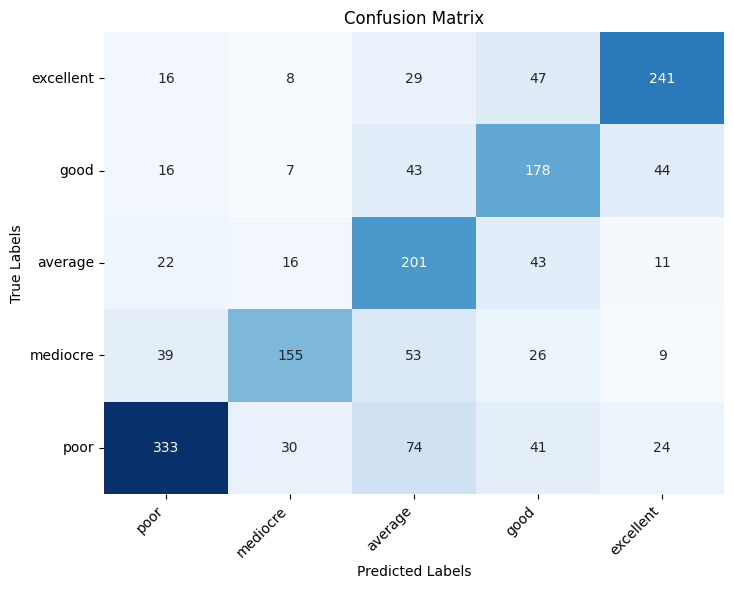

In [25]:
# Convert one-hot encoded y_test to 1-dimensional array
y_test_labels = np.argmax(y_test, axis=1)
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

X_train_vect_avg = np.array(X_train_vect_avg, dtype=np.float32)
X_test_vect_avg = np.array(X_test_vect_avg, dtype=np.float32)
X_val_vect_avg = np.array(X_val_vect_avg, dtype=np.float32)

# Define the input shape based on X_train_vect_avg
input_shape = X_train_vect_avg.shape[1:]

# Model architecture
input_text = Input(shape=input_shape)
word_encoder = Dense(units=64, activation='relu')(input_text)
interaction = Dense(units=5, activation='softmax')(word_encoder)
output = Dense(units=5, activation='softmax')(interaction)

# Build the model
model = Model(inputs=input_text, outputs=output)

# Load the model weights
model.load_weights('/content/drive/MyDrive/covers/model_3_weights/EXAM_weights.h5')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Use the trained model to make predictions on the test data
y_pred_prob = model.predict(X_test_vect_avg)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test_labels, y_pred, average='macro')
recall = recall_score(y_test_labels, y_pred, average='macro')
accuracy = (y_pred == y_test_labels).sum() / len(y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test_labels, y_pred, target_names=labels)
print("Classification Report:")
print(report)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test_labels]
y_pred_decoded = [mapping_dict[label] for label in y_pred]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()


In [26]:
input_shape

(1763,)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1763)]            0         
                                                                 
 dense (Dense)               (None, 64)                112896    
                                                                 
 dense_1 (Dense)             (None, 5)                 325       
                                                                 
 dense_2 (Dense)             (None, 5)                 30        
                                                                 
Total params: 113,251
Trainable params: 113,251
Non-trainable params: 0
_________________________________________________________________


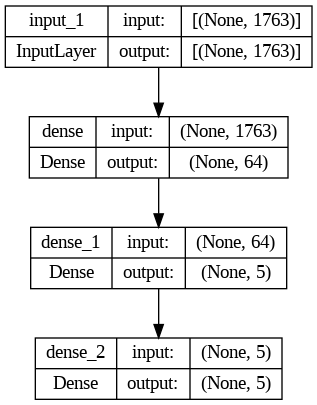

In [ ]:
# Generate a diagram of the model
plot_model(model, to_file='model_diagram.png', show_shapes=True)

# Display the generated diagram
img = Image.open('model_diagram.png')
img.show()

Epoch 1/100
171/171 [==============================] - 1s 4ms/step - loss: 1.2831 - val_loss: 1.2470
Epoch 2/100
171/171 [==============================] - 0s 3ms/step - loss: 0.5118 - val_loss: 1.4335
Epoch 3/100
171/171 [==============================] - 1s 3ms/step - loss: 0.2811 - val_loss: 1.6939
Epoch 4/100
171/171 [==============================] - 1s 4ms/step - loss: 0.2075 - val_loss: 1.8615
Epoch 5/100
171/171 [==============================] - 1s 4ms/step - loss: 0.1610 - val_loss: 2.0242
Epoch 6/100
171/171 [==============================] - 1s 4ms/step - loss: 0.1320 - val_loss: 2.2123
Epoch 7/100
171/171 [==============================] - 1s 4ms/step - loss: 0.1159 - val_loss: 2.3476
Epoch 8/100
171/171 [==============================] - 1s 4ms/step - loss: 0.1059 - val_loss: 2.5183
Epoch 9/100
171/171 [==============================] - 1s 4ms/step - loss: 0.0992 - val_loss: 2.7063
Epoch 10/100
171/171 [==============================] - 1s 4ms/step - loss: 0.0982 - val_lo

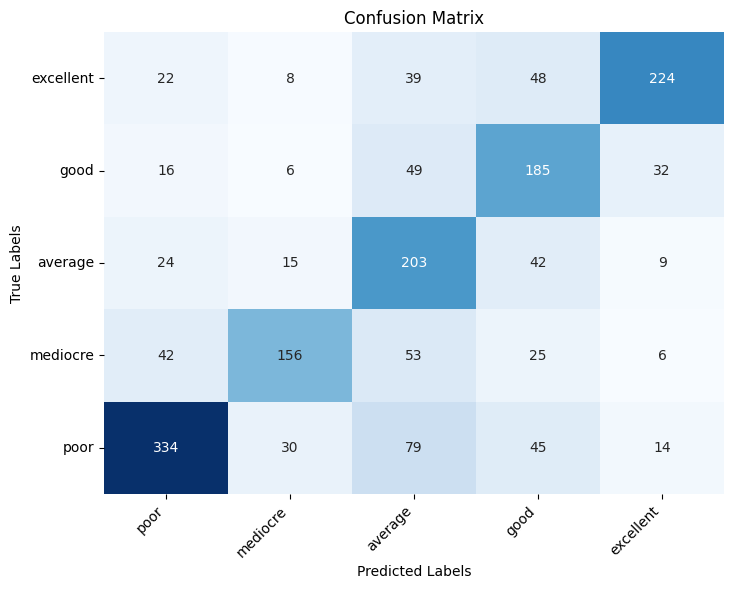

In [ ]:
# Convert one-hot encoded y_test to 1-dimensional array
y_test_labels = np.argmax(y_test, axis=1)
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

X_train_vect_avg = np.array(X_train_vect_avg, dtype=np.float32)
X_test_vect_avg = np.array(X_test_vect_avg, dtype=np.float32)
X_val_vect_avg = np.array(X_val_vect_avg, dtype=np.float32)

# Define the input shape based on X_train_vect_avg
input_shape = X_train_vect_avg.shape[1:]

# Model architecture
input_text = Input(shape=input_shape)
word_encoder = Dense(units=64, activation='relu')(input_text)
interaction = Dense(units=5, activation='softmax')(word_encoder)
output = Dense(units=5, activation='softmax')(interaction)

# Build the model
model = Model(inputs=input_text, outputs=output)

# Load the model weights
model.load_weights('/content/drive/MyDrive/covers/model_3_weights/EXAM_weights.h5')

# Freeze the previously loaded layers
for layer in model.layers[:-2]:
    layer.trainable = False

# Add new trainable layers
new_layer1 = Dense(units=32, activation='relu')(model.layers[-2].output)
new_layer2 = Dense(units=16, activation='relu')(new_layer1)
new_output = Dense(units=5, activation='softmax')(new_layer2)

model = Model(inputs=model.input, outputs=new_output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Train the model
model.fit(X_train_vect_avg, y_train, epochs=100, batch_size=32, validation_data=(X_val_vect_avg, y_val))

# Save the best model weights
save_dir = '/content/drive/MyDrive/covers/model_3_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'simple_NN_weights.h5'))

# Use the trained model to make predictions on the test data
y_pred_prob = model.predict(X_test_vect_avg)
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test_labels, y_pred, average='macro')
recall = recall_score(y_test_labels, y_pred, average='macro')
accuracy = (y_pred == y_test_labels).sum() / len(y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test_labels, y_pred, target_names=labels)
print("Classification Report:")
print(report)

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test_labels]
y_pred_decoded = [mapping_dict[label] for label in y_pred]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()


In [ ]:
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1763)]            0         
                                                                 
 dense_27 (Dense)            (None, 64)                112896    
                                                                 
 dense_28 (Dense)            (None, 5)                 325       
                                                                 
 dense_30 (Dense)            (None, 32)                192       
                                                                 
 dense_31 (Dense)            (None, 16)                528       
                                                                 
 dense_32 (Dense)            (None, 5)                 85        
                                                                 
Total params: 114,026
Trainable params: 1,130
Non-trainabl

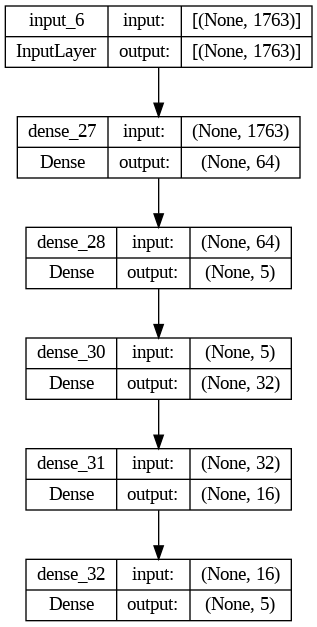

In [ ]:
# Generate a diagram of the model
plot_model(model, to_file='model_diagram.png', show_shapes=True)

# Display the generated diagram
img = Image.open('model_diagram.png')
img.show()

# EXAN

In [ ]:
# Convert one-hot encoded y_test to 1-dimensional array
y_test_labels = np.argmax(y_test, axis=1)
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

X_train_vect_avg = np.array(X_train_vect_avg, dtype=np.float32)
X_test_vect_avg = np.array(X_test_vect_avg, dtype=np.float32)
X_val_vect_avg = np.array(X_val_vect_avg, dtype=np.float32)

# Define the input shapes for word and concept levels
word_input_shape = X_train_vect_avg.shape[1:]
concept_input_shape = X_train_vect_avg.shape[1:]

# Concept embedding layer
concept_input = Input(shape=concept_input_shape)
concept_embedding = Dense(units=64, activation='relu')(concept_input)

# Word embedding layer
word_input = Input(shape=word_input_shape)
word_embedding = Dense(units=64, activation='relu')(word_input)

# Multi-level attention layer for word-level features
word_attention_hidden = Dense(units=64, activation='relu')(word_embedding)
word_attention_weights = Dense(units=word_input_shape[0], activation='softmax')(word_attention_hidden)
word_contextual_features = Concatenate()([word_attention_weights, word_embedding])

# Multi-level attention layer for concept-level features
concept_attention_hidden = Dense(units=64, activation='relu')(concept_embedding)
concept_attention_weights = Dense(units=concept_input_shape[0], activation='softmax')(concept_attention_hidden)
concept_contextual_features = Concatenate()([concept_attention_weights, concept_embedding])

# Merge word and concept level features
merged_features = Concatenate()([word_contextual_features, concept_contextual_features])

# Reshape merged features to 3-dimensional shape
reshaped_features = Reshape(target_shape=(merged_features.shape[1], 1))(merged_features)

# Dilated convolutional layers
conv = Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(reshaped_features)
dropout = Dropout(0.2)(conv)
global_max_pooling = GlobalMaxPooling1D()(dropout)

# Output layer
output = Dense(units=5, activation='softmax')(global_max_pooling)

# Build the model
model = Model(inputs=[word_input, concept_input], outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy')

# Train the model
model.fit([X_train_vect_avg, X_train_vect_avg], y_train, epochs=50, batch_size=32, validation_data=([X_val_vect_avg, X_val_vect_avg], y_val))

# Use the trained model to make predictions on the test data
y_pred_prob = model.predict([X_test_vect_avg, X_test_vect_avg])
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test_labels, y_pred, average='macro')
recall = recall_score(y_test_labels, y_pred, average='macro')
accuracy = (y_pred == y_test_labels).sum() / len(y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test_labels, y_pred, target_names=labels)
print("Classification Report:")
print(report)

# Save the best model weights
save_dir = '/content/drive/MyDrive/covers/model_3_weights'
os.makedirs(save_dir, exist_ok=True)
model.save_weights(os.path.join(save_dir, 'EXAM_1_weights.h5'))

# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test_labels]
y_pred_decoded = [mapping_dict[label] for label in y_pred]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()


## Load Model

In [ ]:
# Define the input shapes for word and concept levels
word_input_shape = X_train_vect_avg.shape[1:]
concept_input_shape = X_train_vect_avg.shape[1:]

# Concept embedding layer
concept_input = Input(shape=concept_input_shape)
concept_embedding = Dense(units=64, activation='relu')(concept_input)

# Word embedding layer
word_input = Input(shape=word_input_shape)
word_embedding = Dense(units=64, activation='relu')(word_input)

# Multi-level attention layer for word-level features
word_attention_hidden = Dense(units=64, activation='relu')(word_embedding)
word_attention_weights = Dense(units=word_input_shape[0], activation='softmax')(word_attention_hidden)
word_contextual_features = Concatenate()([word_attention_weights, word_embedding])

# Multi-level attention layer for concept-level features
concept_attention_hidden = Dense(units=64, activation='relu')(concept_embedding)
concept_attention_weights = Dense(units=concept_input_shape[0], activation='softmax')(concept_attention_hidden)
concept_contextual_features = Concatenate()([concept_attention_weights, concept_embedding])

# Merge word and concept level features
merged_features = Concatenate()([word_contextual_features, concept_contextual_features])

# Reshape merged features to 3-dimensional shape
reshaped_features = Reshape(target_shape=(merged_features.shape[1], 1))(merged_features)

# Dilated convolutional layers
conv = Conv1D(filters=64, kernel_size=3, dilation_rate=1, activation='relu')(reshaped_features)
dropout = Dropout(0.2)(conv)
global_max_pooling = GlobalMaxPooling1D()(dropout)

# Output layer
output = Dense(units=5, activation='softmax')(global_max_pooling)

# Build the model
model = Model(inputs=[word_input, concept_input], outputs=output)

# Load the weights
model.load_weights('/content/drive/MyDrive/covers/model_3_weights/EXAM_1_weights.h5')


In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 1763)]       0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None, 1763)]       0           []                               
                                                                                                  
 dense_34 (Dense)               (None, 64)           112896      ['input_14[0][0]']               
                                                                                                  
 dense_33 (Dense)               (None, 64)           112896      ['input_13[0][0]']               
                                                                                            

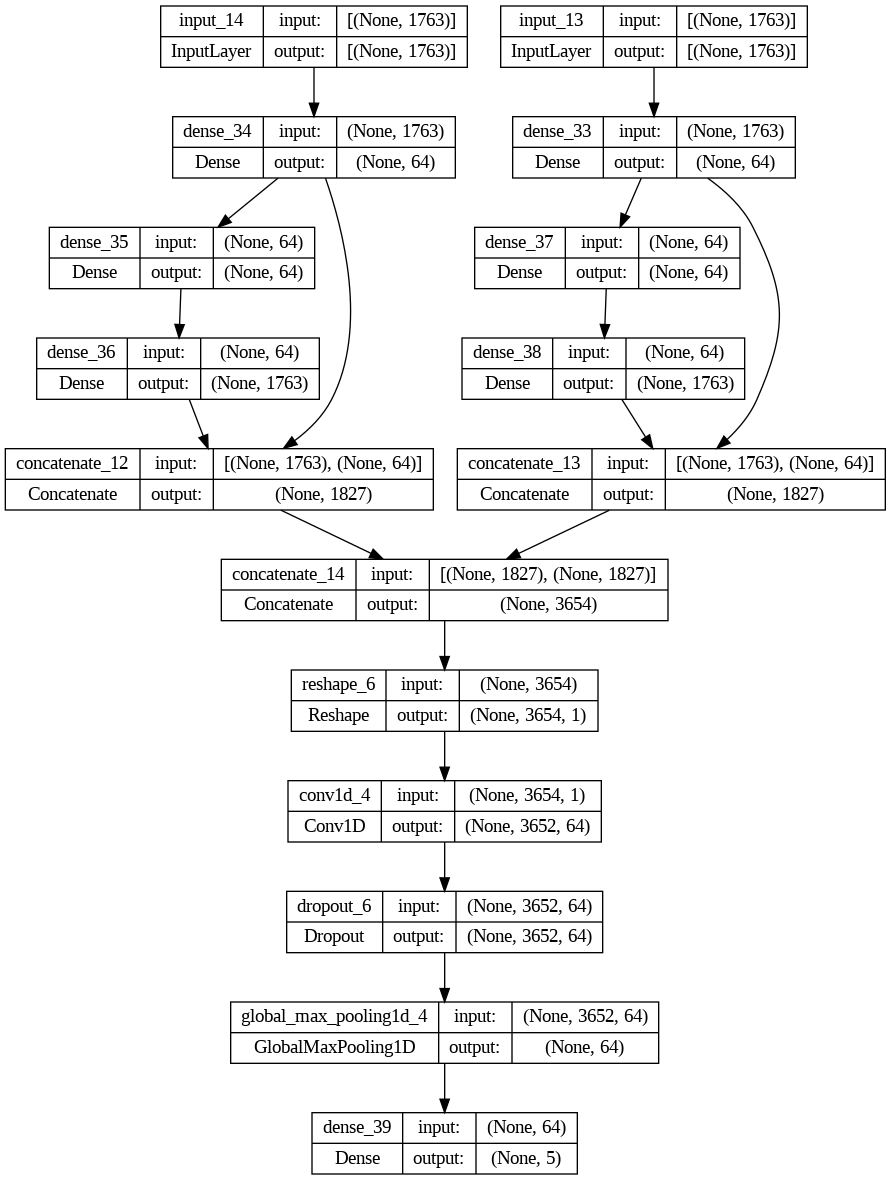

In [ ]:
# Generate a diagram of the model
plot_model(model, to_file='model_diagram.png', show_shapes=True)

# Display the generated diagram
img = Image.open('model_diagram.png')
img.show()


54/54 [==============================] - 2s 28ms/step
Precision: 0.51 / Recall: 0.506 / Accuracy: 0.522
Classification Report:
              precision    recall  f1-score   support

        poor       0.41      0.44      0.42       293
    mediocre       0.65      0.57      0.60       341
     average       0.48      0.48      0.48       288
        good       0.40      0.42      0.41       282
   excellent       0.62      0.62      0.62       502

    accuracy                           0.52      1706
   macro avg       0.51      0.51      0.51      1706
weighted avg       0.53      0.52      0.52      1706



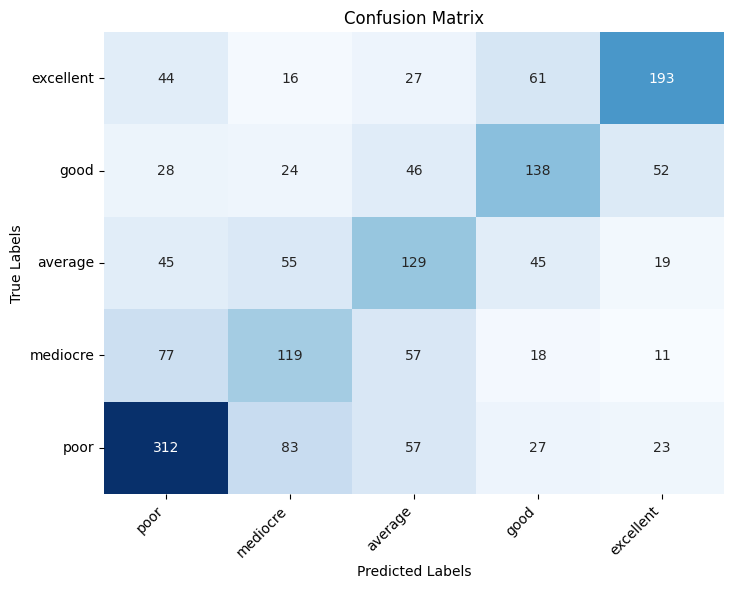

In [ ]:
# Use the trained model to make predictions on the test data
y_pred_prob = model.predict([X_test_vect_avg, X_test_vect_avg])
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate precision, recall, and accuracy scores
precision = precision_score(y_test_labels, y_pred, average='macro')
recall = recall_score(y_test_labels, y_pred, average='macro')
accuracy = (y_pred == y_test_labels).sum() / len(y_pred)
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3), round(recall, 3), round(accuracy, 3)))

# Generate classification report
report = classification_report(y_test_labels, y_pred, target_names=labels)
print("Classification Report:")
print(report)


# Decode the one-hot encoded labels to original labels using the mapping_dict
y_test_decoded = [mapping_dict[label] for label in y_test_labels]
y_pred_decoded = [mapping_dict[label] for label in y_pred]

# Create the confusion matrix
cm = confusion_matrix(y_test_decoded, y_pred_decoded, labels=labels)

# Plot the confusion matrix with custom labels
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Customize tick labels
tick_labels = labels
plt.xticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(tick_labels)) + 0.5, labels=tick_labels, rotation=0, va='center')

# Invert the y-axis
plt.gca().invert_yaxis()

plt.show()